In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import curve_fit

%matplotlib inline

## Importando os dados da instituição

In [2]:
realizados = pd.read_csv('realizados.txt', sep='\t', decimal=',', header=0)

In [3]:
realizados.head()

,DAP,comprimento,altura,CQE,UM
0,16,34,165,56.4,2206
1,18,30,170,51.0,2241
2,18,30,170,51.0,2257
3,19,35,190,59.1,2279
4,19,38,190,63.3,2278


    Criar uma lista com varios pacientes
    Cada um cotem, em coluna os valores ALEATÓRIOS de DAP, altura e comprimento
    Executar a função monitor_unit para cada uma deles

In [4]:
bd = pd.read_csv('bd.txt', sep="\t", decimal='.', header=0, index_col=0)
sp = pd.read_csv('sp.txt', sep="\t", decimal='.', header=0, index_col=0)
tpr = pd.read_csv('tpr.txt', sep="\t", decimal='.', header=0, index_col=0)

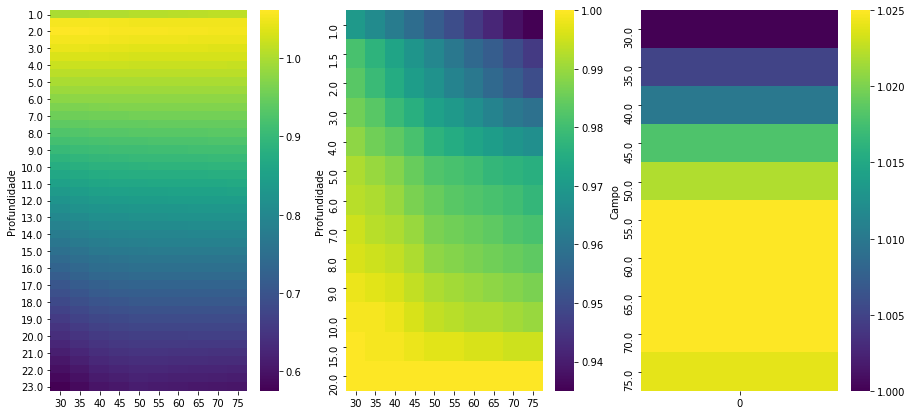

In [5]:
plt.figure(figsize=(15,7))
plt.subplot(1,3,1)
sns.heatmap(tpr, cmap='viridis')
plt.subplot(1,3,2)
sns.heatmap(bd, cmap='viridis')
plt.subplot(1,3,3)
sns.heatmap(sp, cmap='viridis')

## Definindo função de criação pacientes virtuais com dimensões discretas em resolução

In [6]:
def newPatiente(number):
    DAP = np.random.randint(16,41, size=number)
    altura = np.random.randint(100,200, size=number)
    comprimento = np.random.randint(20,46, size=number)
    data = pd.DataFrame({'DAP':DAP,
                         'comprimento':comprimento,
                         'altura':altura})
    return data

## Definindo função de CQE

In [7]:
def cqe(altura,comprimento):
    return float(2*(altura*comprimento)/(altura+comprimento))

## Definindo as matrizes de interpolação

In [8]:
tprInterpol = interpolate.interp2d(tpr.columns.astype(float), tpr.index.astype(float), tpr, kind='linear',bounds_error=False)
bdInterpol = interpolate.interp2d(bd.columns.astype(float), bd.index.astype(float), bd, kind='linear', bounds_error=False)
spInterpol = interpolate.interp1d(sp.index.astype(float), sp['0'].astype(float), kind='linear', bounds_error=False, fill_value=(1,1.024))

## Definindo a função de cálculo de Unidade Monitoras

In [9]:
def monitor_unit(Dose_campo,SSD,DAP,altura,comprimento):
    #SAD padrão é 465cm
    CQE=cqe(altura,comprimento)
    IQD = (465/SSD)**2
    Sc = 1.106 #maior campo possível
    Sp = spInterpol(CQE)
    TPR = tprInterpol(CQE,0.5*DAP)
    BD = bdInterpol(CQE,0.5*DAP)
    Calib = 0.04334
    #print("*****************************")
    #print("<> Sp:",Sp)
    #print("<> Sc:",Sc)
    #print("<> Calibracao:",Calib)
    #print("<> TPR:",TPR)
    #print("<> Biuld Down:",BD)
    #print("<> Correcao IQD:",IQD)
    #print("\n")
    #print("UM = ", round(um,0))   
    #print("---------------------------------------------")
    
    return float(Dose_campo/(Sc*Sp*TPR*BD*Calib*IQD))

## Simulando

In [10]:
dataPatiente = newPatiente(10000)
dataTBI = dataPatiente

CQE = []
UM = []

for i in dataPatiente.index:    
    CQE.append(cqe(dataPatiente['altura'][i],dataPatiente['comprimento'][i]))
    UM.append(monitor_unit(100,465,dataPatiente['DAP'][i],dataPatiente['altura'][i],dataPatiente['comprimento'][i]))
    
    #print('.', end=' ')
    #print("Paciente {} completo".format(i))

#TENTAR
#CQE = cqe(dataPatiente['altura'],dataPatiente['comprimento'])
#UM = monitor_unit(100,465,dataPatiente['DAP'],dataPatiente['altura'],dataPatiente['comprimento'])
       
dataTBI['CQE'] = CQE
dataTBI['UM'] = UM

print('\nFinalizado!')


Finalizado!


In [11]:
dataTBI.head()

,DAP,comprimento,altura,CQE,UM
0,40,31,196,53.533040,3058.658313
1,33,42,177,67.890411,2753.399411
2,27,26,158,44.652174,2553.971934
3,22,41,126,61.868263,2366.274348
4,23,22,159,38.651934,2441.630065


In [12]:
dataTBI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DAP          10000 non-null  int64  
 1   comprimento  10000 non-null  int64  
 2   altura       10000 non-null  int64  
 3   CQE          10000 non-null  float64
 4   UM           10000 non-null  float64
dtypes: float64(2), int64(3)
memory usage: 390.8 KB


In [13]:
#sns.barplot(dataTBI['DAP'].value_counts().index, dataTBI['DAP'].value_counts(), palette='rainbow')

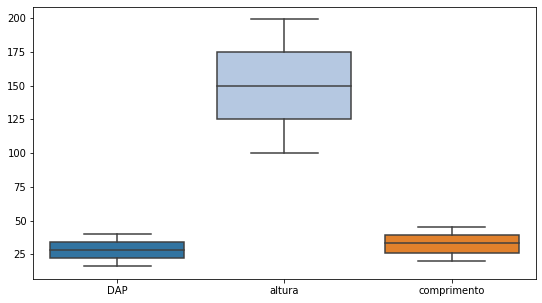

In [14]:
plt.figure(figsize=(9,5))
sns.boxplot(data=dataTBI[['DAP', 'altura', 'comprimento']], palette='tab20')

In [15]:
dataTBI.corr()

,DAP,comprimento,altura,CQE,UM
DAP,1.000000,0.003554,0.019574,0.007963,0.991253
comprimento,0.003554,1.000000,0.004157,0.978116,-0.077293
altura,0.019574,0.004157,1.000000,0.194746,0.007146
CQE,0.007963,0.978116,0.194746,1.000000,-0.074715
UM,0.991253,-0.077293,0.007146,-0.074715,1.000000


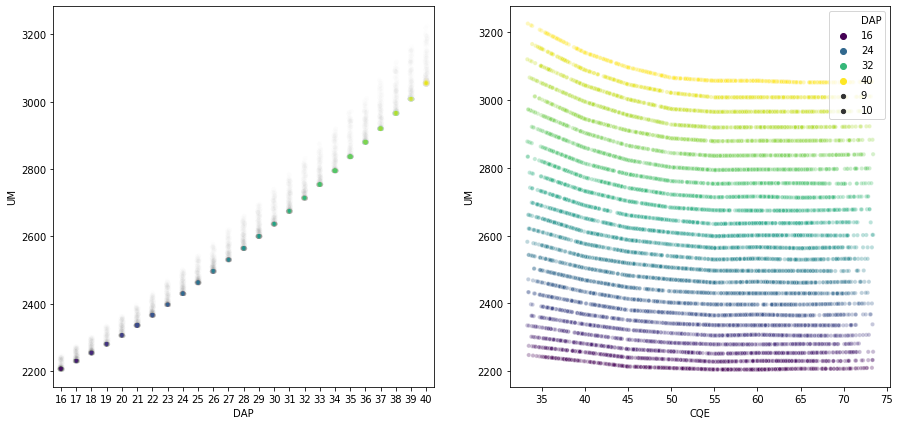

In [16]:
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
sns.stripplot(dataTBI['DAP'], 'UM', data=dataTBI, palette='viridis', alpha=0.005)
plt.subplot(1,2,2)
sns.scatterplot('CQE', 'UM', data=dataTBI, hue='DAP', palette='viridis', alpha=0.3, size=10)


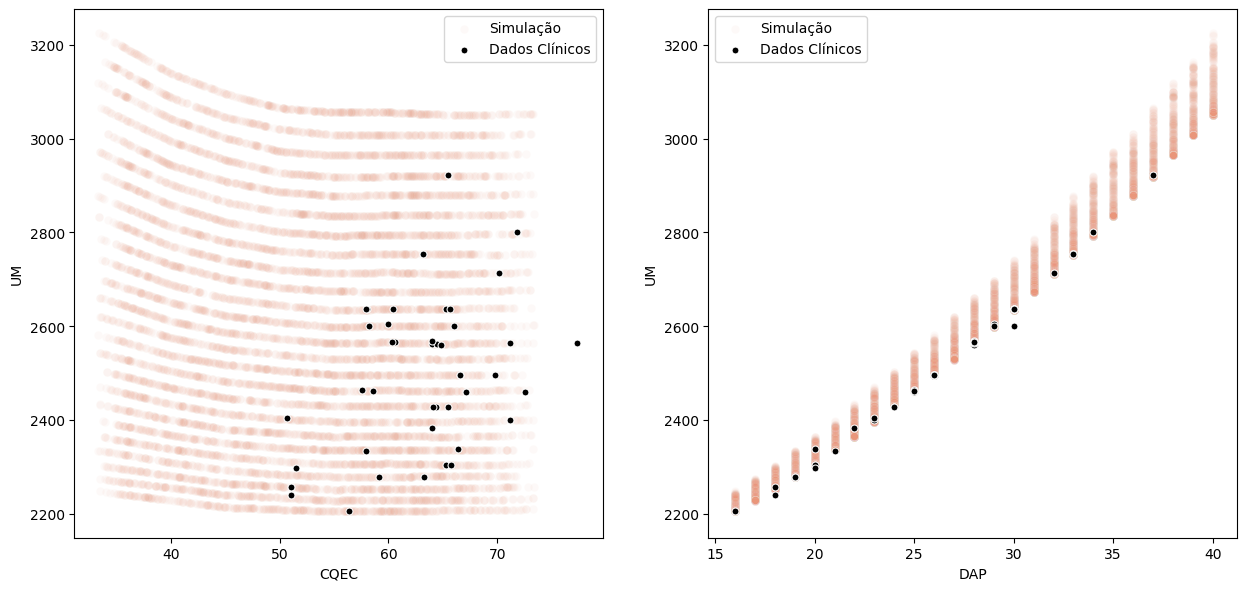

In [36]:
fig, ax = plt.subplots(1,2, figsize=(15,7), dpi=100)
sns.scatterplot(dataTBI['CQE'], dataTBI['UM'], color='darksalmon', lw=2, alpha=0.05, label='Simulação', ax=ax[0])
sns.scatterplot(realizados['CQE'], realizados['UM'], color='black', marker='.', s=100, label='Dados Clínicos', ax=ax[0])
ax[0].legend(loc=0)
ax[0].set_xlabel("CQEC")

sns.scatterplot(dataTBI['DAP'], dataTBI['UM'], color='darksalmon', lw=3, alpha=0.05, label='Simulação', ax=ax[1])
sns.scatterplot(realizados['DAP'], realizados['UM'], color='black',marker='.', s=100, label='Dados Clínicos', ax=ax[1])
ax[1].legend(loc=0)

## Fitando os dados de simulação

In [18]:
def previsionUM(x, a, b, c, d):
    return a*np.exp(b*x + c*x**2+d*x**3)

In [19]:
popt=pd.Series([])
pcov=pd.Series([])
for i in np.arange(dataTBI['DAP'].min(),dataTBI['DAP'].max()+1):
    try: 
        xdata=dataTBI[dataTBI['DAP']==i]['CQE']
        ydata=dataTBI[dataTBI['DAP']==i]['UM']

        popt[i]=curve_fit(previsionUM, xdata, ydata, p0=[0,0.0001,0.00001,0.00001])[0]
        pcov[i]=curve_fit(previsionUM, xdata, ydata, p0=[0,0.0001,0.00001,0.00001])[1]
        #print('.', end=' ')
        #print('DAP: {} (V)'.format(i))
        
    except ValueError:
        print('DAP: {} (X)'.format(i))

/home/pedrocoelho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.
/home/pedrocoelho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


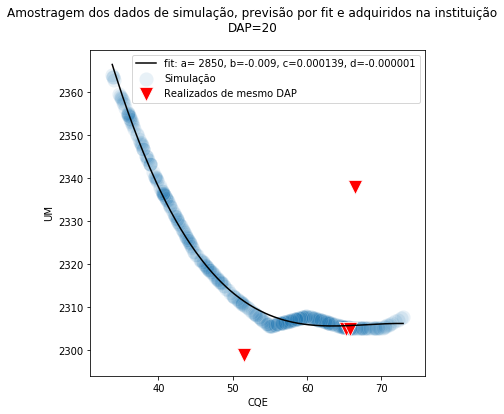

In [20]:
j=20
fig=plt.figure(figsize=(6,6))
fig.suptitle('Amostragem dos dados de simulação, previsão por fit e adquiridos na instituição\nDAP={}'.format(j))
sns.lineplot(dataTBI[dataTBI['DAP']==j]['CQE'],
             previsionUM(dataTBI[dataTBI['DAP']==j]['CQE'], *popt[j]),
             color='black',
             label='fit: a=%5.f, b=%.3f, c=%.6f, d=%.6f' % tuple(popt[j]))
sns.scatterplot(dataTBI[dataTBI['DAP']==j]['CQE'],
             dataTBI[dataTBI['DAP']==j]['UM'],
             alpha=0.1, s=200, label='Simulação')
sns.scatterplot(realizados[realizados['DAP']==j]['CQE'], realizados[realizados['DAP']==j]['UM'], marker='v', s=200, color='red', label='Realizados de mesmo DAP')

In [21]:
a=[]
b=[]
c=[]
d=[]
for i in popt.index:
    a.append(popt[i][0])
    b.append(popt[i][1])
    c.append(popt[i][2])
    d.append(popt[i][3])

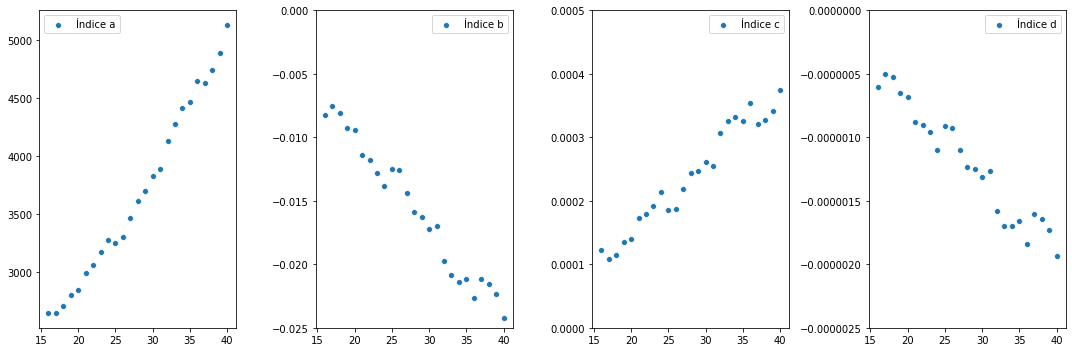

In [22]:
fig, ax = plt.subplots(1,4, figsize=(15,5))
sns.scatterplot(popt.index, a, label='Índice a', ax=ax[0])
sns.scatterplot(popt.index, b, label='Índice b', ax=ax[1])
sns.scatterplot(popt.index, c, label='Índice c', ax=ax[2])
sns.scatterplot(popt.index, d, label='Índice d', ax=ax[3])
ax[1].set_ylim(-0.025,0)
ax[2].set_ylim(0,0.0005)
ax[3].set_ylim(-0.0000025,0)
plt.tight_layout()

## Fitando os dados dos indices dos fits (a,b,c,d)

In [23]:
def linear(x, a, b):
    return a*x + b

In [24]:
def quadrado(x, a, b, c):
    return a*x**2 + b*x + c

In [25]:
for i in popt.index:
    A=curve_fit(quadrado, popt.index, a)[0]
    B=curve_fit(linear, popt.index, b)[0]
    C=curve_fit(linear, popt.index, c)[0]
    D=curve_fit(linear, popt.index, d)[0]

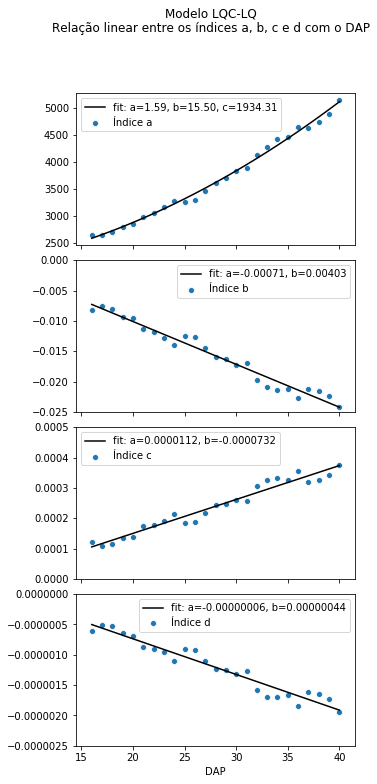

In [26]:
fig, ax = plt.subplots(4, sharex=True, figsize=(5,12), gridspec_kw={'hspace': .1})
fig.suptitle('Modelo LQC-LQ\nRelação linear entre os índices a, b, c e d com o DAP')
ax[1].set_ylim(-0.025,0)
ax[2].set_ylim(0,0.0005)
ax[3].set_ylim(-0.0000025,0)
ax[3].set_xlabel('DAP')
sns.scatterplot(popt.index, a, label='Índice a', ax=ax[0])
sns.lineplot(popt.index,
             quadrado(popt.index, *A),
             label='fit: a=%.2f, b=%.2f, c=%.2f' % tuple(A),
             color='black', ax=ax[0])

sns.scatterplot(popt.index, b, label='Índice b', ax=ax[1])
sns.lineplot(popt.index,
             linear(popt.index, *B),
             label='fit: a=%.5f, b=%.5f' % tuple(B),
             color='black', ax=ax[1])

sns.scatterplot(popt.index, c,label='Índice c', ax=ax[2])
sns.lineplot(popt.index,
             linear(popt.index, *C),
             label='fit: a=%.7f, b=%.7f' % tuple(C),
             color='black', ax=ax[2])

sns.scatterplot(popt.index, d,label='Índice d', ax=ax[3])
sns.lineplot(popt.index,
             linear(popt.index, *D),
             label='fit: a=%.8f, b=%.8f' % tuple(D),
             color='black', ax=ax[3])

plt.savefig('LQC-LQ.png', dpi=300)

In [27]:
pd.DataFrame({'DAP':popt.index,
             'a':a, 'b':b, 'c':c},
            columns=['DAP', 'a', 'b', 'c']).corr()

,DAP,a,b,c
DAP,1.000000,0.992313,-0.984632,0.978377
a,0.992313,1.000000,-0.988673,0.984246
b,-0.984632,-0.988673,1.000000,-0.999334
c,0.978377,0.984246,-0.999334,1.000000


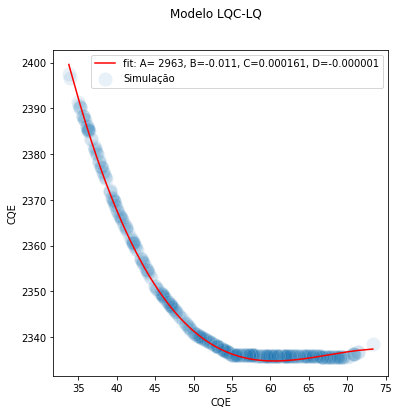

In [28]:
j=21
x=dataTBI[dataTBI['DAP']==j]['CQE']
fig=plt.figure(figsize=(6,6))
#fig.suptitle('Amostragem dos dados de simulação, previsão por fit e adquiridos na instituição\nDAP={}'.format(j))
fig.suptitle("Modelo LQC-LQ")
#sns.lineplot(x,
#             previsionUM(x, *popt[j]),
#             color='black',
#             label='fit: a=%5.f, b=%.3f, c=%.6f, d=%.6f' % tuple(popt[j]))
sns.scatterplot(x,
             dataTBI[dataTBI['DAP']==j]['UM'],
             alpha=0.1, s=200, label='Simulação')
#sns.scatterplot(realizados[realizados['DAP']==j]['CQE'], realizados[realizados['DAP']==j]['UM'], marker='v', s=200, color='red', label='Realizados')
sns.lineplot(x,
                previsionUM(x, quadrado(j, *A), linear(j, *B), linear(j, *C), linear(j, *D)),
                color='red',
                label='fit: A=%5.f, B=%.3f, C=%.6f, D=%.6f' % tuple([quadrado(j, *A), linear(j, *B), linear(j, *C), linear(j, *D)]))


In [29]:
A,B,C,D

(array([1.59444888e+00, 1.55027704e+01, 1.93430648e+03]),
 array([-0.00070566,  0.00402929]),
 array([ 1.11711244e-05, -7.32139526e-05]),
 array([-5.87465246e-08,  4.37991360e-07]))

## Analisando os dados da instituição com o modelo estabelecido

Lembre que os dados da instituição estão armazenados no DataFrame: realizados \\\
Os dados de simulação estão armazenados em \\\
A equação encontrada pode ser obtida por meio da relação:\\\
previsionUM(x,linear(j, *A).round(0), linear(j, *B).round(6), linear(j, *C).round(7), linear(j, *D).round(8))\\\
-->no qual x=dataTBI[dataTBI['DAP']==j]['CQE'] \\\
-->j a escolha do CQE de interesse

In [30]:
UMexact=[]
for i in realizados.index:
    UMexact.append(monitor_unit(100,465,realizados['DAP'][i],realizados['altura'][i],realizados['comprimento'][i]))
    
realizados['UM exact']=UMexact

In [31]:
UMest=[]
for i in realizados.index:
    cqe=realizados['CQE'][i]
    dap=realizados['DAP'][i]
    UMest.append(previsionUM(cqe,quadrado(dap, *A), linear(dap, *B), linear(dap, *C), linear(dap, *D)))
    
realizados['UM est']=UMest

In [32]:
#realizados

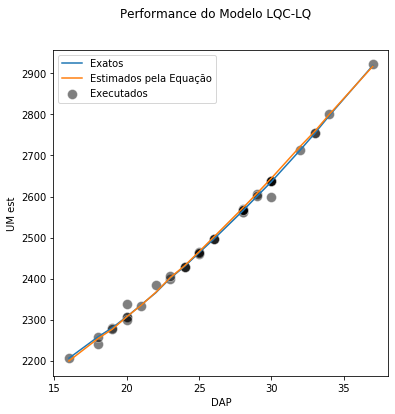

In [33]:
fig=plt.figure(figsize=(6,6))
fig.suptitle('Performance do Modelo LQC-LQ')
sns.scatterplot(realizados['DAP'], realizados['UM'], data=realizados, label='Executados', color='black', s=100, alpha=.5)
sns.lineplot(realizados['DAP'], realizados['UM exact'], data=realizados, label='Exatos')
sns.lineplot(realizados['DAP'], realizados['UM est'], data=realizados, label='Estimados pela Equação')

plt.savefig('LQC-LQ-realizados.png', dpi=300)

In [34]:
realizados.to_csv('realizados_LQC-LQ.csv')